In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import pandas as pd


In [71]:
data = load_iris()

In [72]:
# Generate synthetic dataset
# X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, 
#                          n_redundant=5, n_classes=3, random_state=42)

X = data.data
y = data.target

In [73]:
X,y

(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
        [5

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [75]:
class ANN(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], num_classes)
        self.relu = nn.ReLU()    
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [76]:
verified_model = ANN(input_size=4, hidden_sizes=[64, 32], num_classes=3)

In [77]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(verified_model.parameters(), lr=0.001)

In [78]:
# Training loop
epochs = 30
for epoch in range(epochs):
    verified_model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = verified_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss/len(train_loader):.4f}')

Epoch [5/30], Loss: 0.9381
Epoch [10/30], Loss: 0.6790
Epoch [15/30], Loss: 0.4678
Epoch [20/30], Loss: 0.3490
Epoch [25/30], Loss: 0.2802
Epoch [30/30], Loss: 0.2178


In [79]:
# Evaluation
verified_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = verified_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

verified_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = verified_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Train Accuracy: {100 * correct / total:.2f}%')


Test Accuracy: 100.00%
Train Accuracy: 95.00%


In [80]:
activations = {}
def get_activation(name, storage_dict):
    def hook(model, input, output):
        storage_dict[name] = output.detach()
    return hook

verified_model.fc1.register_forward_hook(get_activation('fc1', activations))
verified_model.fc2.register_forward_hook(get_activation('fc2', activations))
verified_model.fc3.register_forward_hook(get_activation('fc3', activations))

In [81]:
calibration_data = X_train[0]

# Get verified activations from original model
verified_model.eval()
with torch.no_grad():
    _ = verified_model(calibration_data)
    target_activations = {k: v.clone() for k, v in activations.items()}

real_activations = target_activations.copy()

# ADVERSARY SETUP

In [ ]:
def crack_input(target_output, model, learning_rate=0.005, iterations=10000):
    # Initialize random input (3 features)
    input_tensor = torch.randn(1, 4, requires_grad=True)
    optimizer = torch.optim.Adam([input_tensor], lr=learning_rate)
    
    losses = []
    for i in range(iterations): 
        optimizer.zero_grad()
    
        # Forward pass
        predicted_output = model(input_tensor)
        
        # Compute loss
        loss = F.mse_loss(predicted_output, target_output)
        losses.append(loss.item())
        
        # Backward pass
        loss.backward()
        
        # Update inputs
        optimizer.step()
        
        # Optional: print progress if loss zero hack is successful!!
        if i % 1000 == 0:
            print(f"Iteration {i}, Loss: {loss.item():.6f}")

        if loss.item() < 1e-6:
            print("Loss is very low, stoped early.")
            break
    return input_tensor.detach()

In [83]:
pred_inputs = crack_input(real_activations['fc3'], verified_model, learning_rate=0.001, iterations=100000)

Iteration 0, Loss: 13.589272


C:\Users\hskay\AppData\Local\Temp\ipykernel_46748\1496419912.py:14: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(predicted_output, target_output)


Iteration 1000, Loss: 2.122372
Iteration 2000, Loss: 0.205654
Iteration 3000, Loss: 0.009585
Iteration 4000, Loss: 0.001140
Iteration 5000, Loss: 0.001040
Iteration 6000, Loss: 0.000963
Iteration 7000, Loss: 0.000851
Iteration 8000, Loss: 0.000699
Iteration 9000, Loss: 0.000517
Iteration 10000, Loss: 0.000339
Iteration 11000, Loss: 0.000209
Iteration 12000, Loss: 0.000141
Iteration 13000, Loss: 0.000103
Iteration 14000, Loss: 0.000066
Iteration 15000, Loss: 0.000032
Iteration 16000, Loss: 0.000010
Loss is very low, stoped early.


Layer fc1 - Mean Absolute Difference: 0.020991
Layer fc1 - Max Absolute Difference: 0.065743


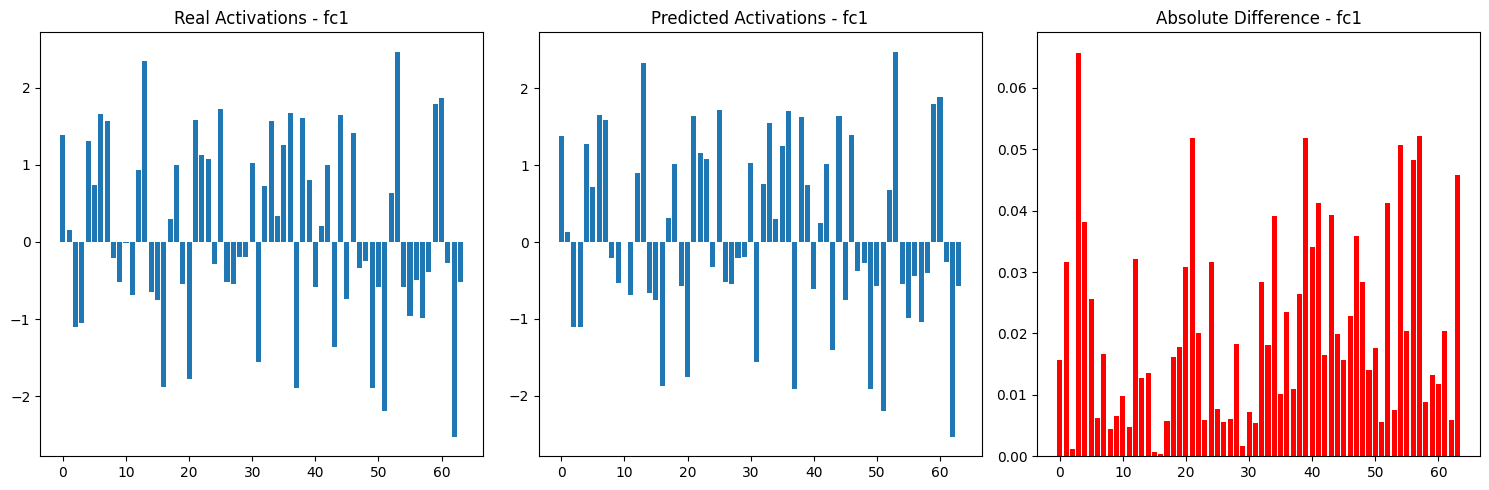

Layer fc2 - Mean Absolute Difference: 0.010133
Layer fc2 - Max Absolute Difference: 0.027059


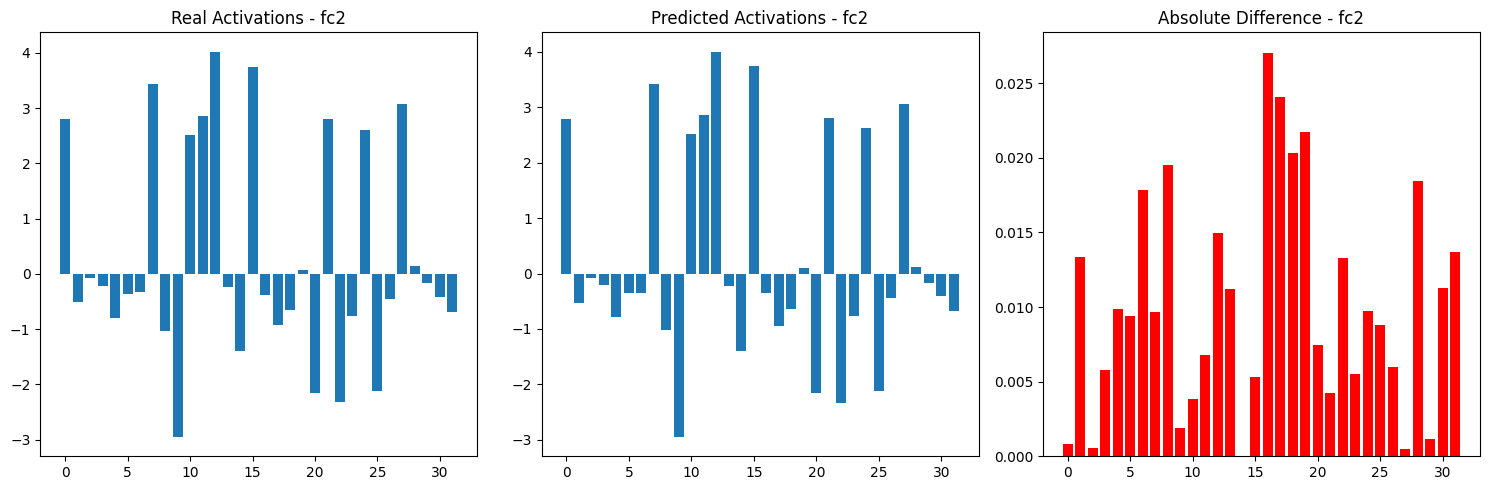

Layer fc3 - Mean Absolute Difference: 0.000989
Layer fc3 - Max Absolute Difference: 0.001131


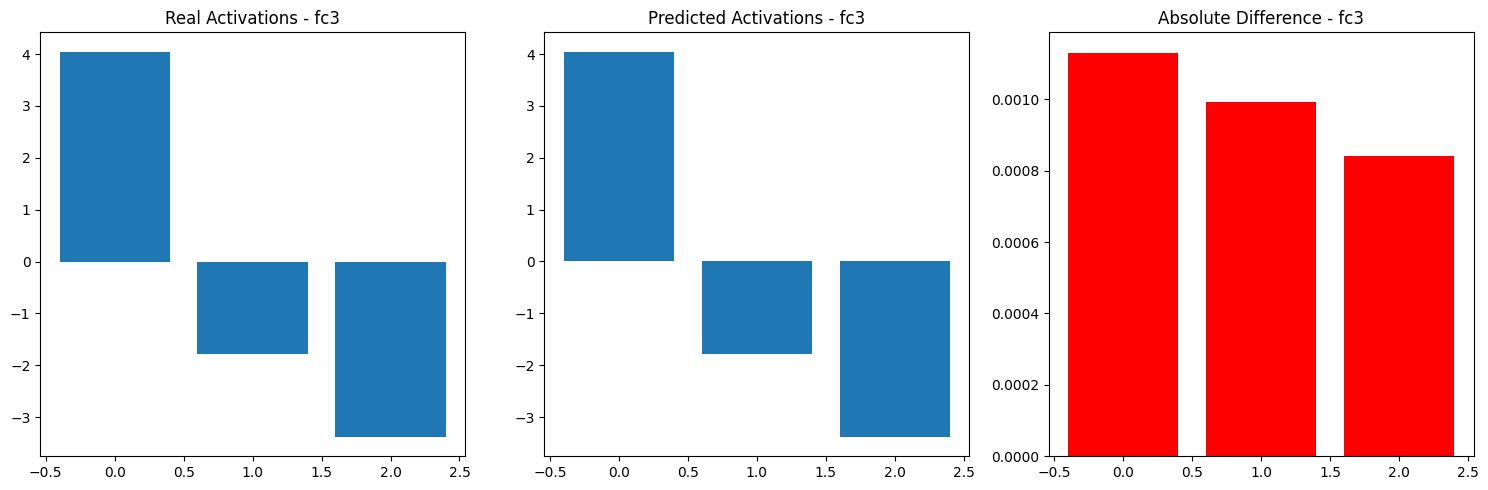

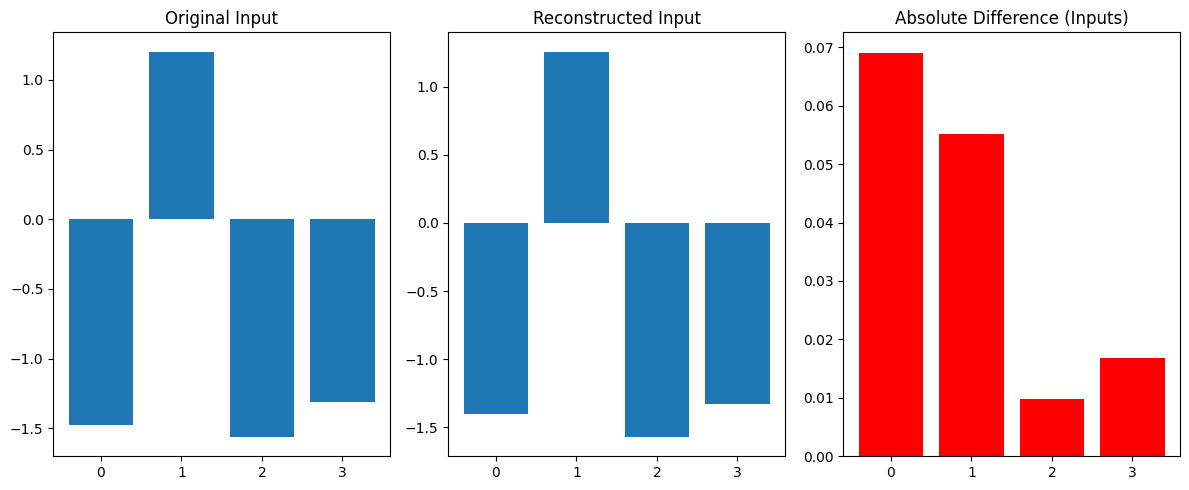

Input - Mean Absolute Difference: 0.037736
Input - Max Absolute Difference: 0.069094


In [84]:
activations = {}
verified_model.fc1.register_forward_hook(get_activation('fc1', activations))
verified_model.fc2.register_forward_hook(get_activation('fc2', activations))
verified_model.fc3.register_forward_hook(get_activation('fc3', activations))

calibration_data = pred_inputs

# Get verified activations from original model
verified_model.eval()
with torch.no_grad():
    _ = verified_model(calibration_data)
    pred_activations = {k: v.clone() for k, v in activations.items()}

# Compare and visualize the activations using absolute difference
for layer in real_activations.keys():
    # Calculate mean absolute error between real and predicted activations
    abs_diff = torch.abs(real_activations[layer] - pred_activations[layer])
    mean_abs_diff = abs_diff.mean().item()
    max_abs_diff = abs_diff.max().item()
    
    print(f"Layer {layer} - Mean Absolute Difference: {mean_abs_diff:.6f}")
    print(f"Layer {layer} - Max Absolute Difference: {max_abs_diff:.6f}")
    
    # Create visualization
    plt.figure(figsize=(15, 5))
    
    # Plot real activations
    plt.subplot(1, 3, 1)
    plt.title(f"Real Activations - {layer}")
    plt.bar(range(len(real_activations[layer].flatten())), 
            real_activations[layer].flatten().numpy())
    
    # Plot predicted activations
    plt.subplot(1, 3, 2)
    plt.title(f"Predicted Activations - {layer}")
    plt.bar(range(len(pred_activations[layer].flatten())), 
            pred_activations[layer].flatten().numpy())
    
    # Plot absolute differences
    plt.subplot(1, 3, 3)
    plt.title(f"Absolute Difference - {layer}")
    plt.bar(range(len(abs_diff.flatten())), 
            abs_diff.flatten().numpy(),
            color='red')
    
    plt.tight_layout()
    plt.savefig(f"activation_comparison_{layer}_first_input.png")
    plt.show()

# Also compare the original input with the reconstructed input
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.title("Original Input")
plt.bar(range(len(X_train[0])), X_train[0].numpy())

plt.subplot(1, 3, 2)
plt.title("Reconstructed Input")
plt.bar(range(len(pred_inputs.flatten())), pred_inputs.flatten().numpy())

# Show absolute difference between inputs
plt.subplot(1, 3, 3)
plt.title("Absolute Difference (Inputs)")
input_abs_diff = torch.abs(X_train[0] - pred_inputs.flatten())
plt.bar(range(len(input_abs_diff)), input_abs_diff.numpy(), color='red')

plt.tight_layout()
plt.savefig(f"input_comparison_first_input.png")
plt.show()

# Print summary statistics for inputs
mean_input_diff = input_abs_diff.mean().item()
max_input_diff = input_abs_diff.max().item()
print(f"Input - Mean Absolute Difference: {mean_input_diff:.6f}")
print(f"Input - Max Absolute Difference: {max_input_diff:.6f}")

# MULTIPLE INPUT with N ROUND

In [87]:
ROUND = 3
N_INPUTS = 50
results = pd.DataFrame(columns=[
    'input_id', 'round_id', 
    'fc1_min_abs_diff', 'fc1_max_abs_diff', 'fc1_mean_abs_diff',
    'fc2_min_abs_diff', 'fc2_max_abs_diff', 'fc2_mean_abs_diff',
    'fc3_min_abs_diff', 'fc3_max_abs_diff', 'fc3_mean_abs_diff',
    'real_input', "pred_input"
])
for i in range(N_INPUTS):
    print(f"Input {i+1}")
    for j in range(ROUND):
        print(f"Round {j+1}")

        # Registering hooks to capture activations
        activations = {}
        verified_model.fc1.register_forward_hook(get_activation('fc1', activations))
        verified_model.fc2.register_forward_hook(get_activation('fc2', activations))
        verified_model.fc3.register_forward_hook(get_activation('fc3', activations))

        calibration_data = X_train[i]

        # Get verified activations from original model
        verified_model.eval()
        with torch.no_grad():
            _ = verified_model(calibration_data)
            target_activations = {k: v.clone() for k, v in activations.items()}

        real_activations = target_activations.copy()


        # ADVERSARIAL INPUT GENERATION
        pred_inputs = crack_input(real_activations['fc3'], verified_model, learning_rate=0.005, iterations=10000)

        # Registering hooks to capture activations
        activations = {}
        verified_model.fc1.register_forward_hook(get_activation('fc1', activations))
        verified_model.fc2.register_forward_hook(get_activation('fc2', activations))
        verified_model.fc3.register_forward_hook(get_activation('fc3', activations))

        calibration_data = pred_inputs

        # ACTIVATIONS that ADVERSARIAL INPUT GENERATED
        verified_model.eval()
        with torch.no_grad():
            _ = verified_model(calibration_data)
            pred_activations = {k: v.clone() for k, v in activations.items()}

        round_results = {'input_id': i+1, 'round_id': j+1}
        
        # Compare and visualize the activations using absolute difference
        for layer in real_activations.keys():

            # Calculate mean absolute error between real and predicted activations
            abs_diff = torch.abs(real_activations[layer] - pred_activations[layer])
            mean_abs_diff = abs_diff.mean().item()
            max_abs_diff = abs_diff.max().item()
            min_abs_diff = abs_diff.min().item()

            # Store in results dictionary
            round_results[f'{layer}_min_abs_diff'] = min_abs_diff
            round_results[f'{layer}_max_abs_diff'] = max_abs_diff
            round_results[f'{layer}_mean_abs_diff'] = mean_abs_diff

        # Append results to DataFrame
        round_results['real_input'] = real_activations['fc3'].flatten().numpy().tolist()
        round_results['pred_input'] = pred_inputs.flatten().numpy().tolist()
        results = pd.concat([results, pd.DataFrame([round_results])], ignore_index=True)
        
            
results.to_csv('activation_diff_results.csv', index=False)




Input 1
Round 1
Iteration 0, Loss: 2.426739


C:\Users\hskay\AppData\Local\Temp\ipykernel_46748\1496419912.py:14: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(predicted_output, target_output)


Iteration 1000, Loss: 0.000637
Iteration 2000, Loss: 0.000608
Iteration 3000, Loss: 0.000562
Iteration 4000, Loss: 0.000492
Iteration 5000, Loss: 0.000396
Iteration 6000, Loss: 0.000210
Iteration 7000, Loss: 0.000070
Iteration 8000, Loss: 0.000017
Loss is very low, stoped early.
Round 2
Iteration 0, Loss: 6.086666


C:\Users\hskay\AppData\Local\Temp\ipykernel_46748\685521976.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([round_results])], ignore_index=True)


Iteration 1000, Loss: 0.011942
Iteration 2000, Loss: 0.006591
Iteration 3000, Loss: 0.002693
Iteration 4000, Loss: 0.000989
Iteration 5000, Loss: 0.000313
Iteration 6000, Loss: 0.000174
Iteration 7000, Loss: 0.000135
Iteration 8000, Loss: 0.000092
Iteration 9000, Loss: 0.000050
Round 3
Iteration 0, Loss: 13.834079
Iteration 1000, Loss: 0.016458
Iteration 2000, Loss: 0.015619
Iteration 3000, Loss: 0.014324
Iteration 4000, Loss: 0.012543
Iteration 5000, Loss: 0.010625
Iteration 6000, Loss: 0.009123
Iteration 7000, Loss: 0.006497
Iteration 8000, Loss: 0.002415
Iteration 9000, Loss: 0.000327
Input 2
Round 1
Iteration 0, Loss: 19.908455
Iteration 1000, Loss: 0.001591
Iteration 2000, Loss: 0.000890
Iteration 3000, Loss: 0.000730
Iteration 4000, Loss: 0.000526
Iteration 5000, Loss: 0.000312
Iteration 6000, Loss: 0.000164
Iteration 7000, Loss: 0.000071
Iteration 8000, Loss: 0.000032
Iteration 9000, Loss: 0.000012
Round 2
Iteration 0, Loss: 25.963852
Iteration 1000, Loss: 0.005767
Iteration 200

C:\Users\hskay\AppData\Local\Temp\ipykernel_46748\3570239640.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=categories, y=flat_data, palette=colors)
C:\Users\hskay\AppData\Local\Temp\ipykernel_46748\3570239640.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=categories, y=flat_data, palette=colors)
C:\Users\hskay\AppData\Local\Temp\ipykernel_46748\3570239640.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=categories, y=flat_data, palette=colors)


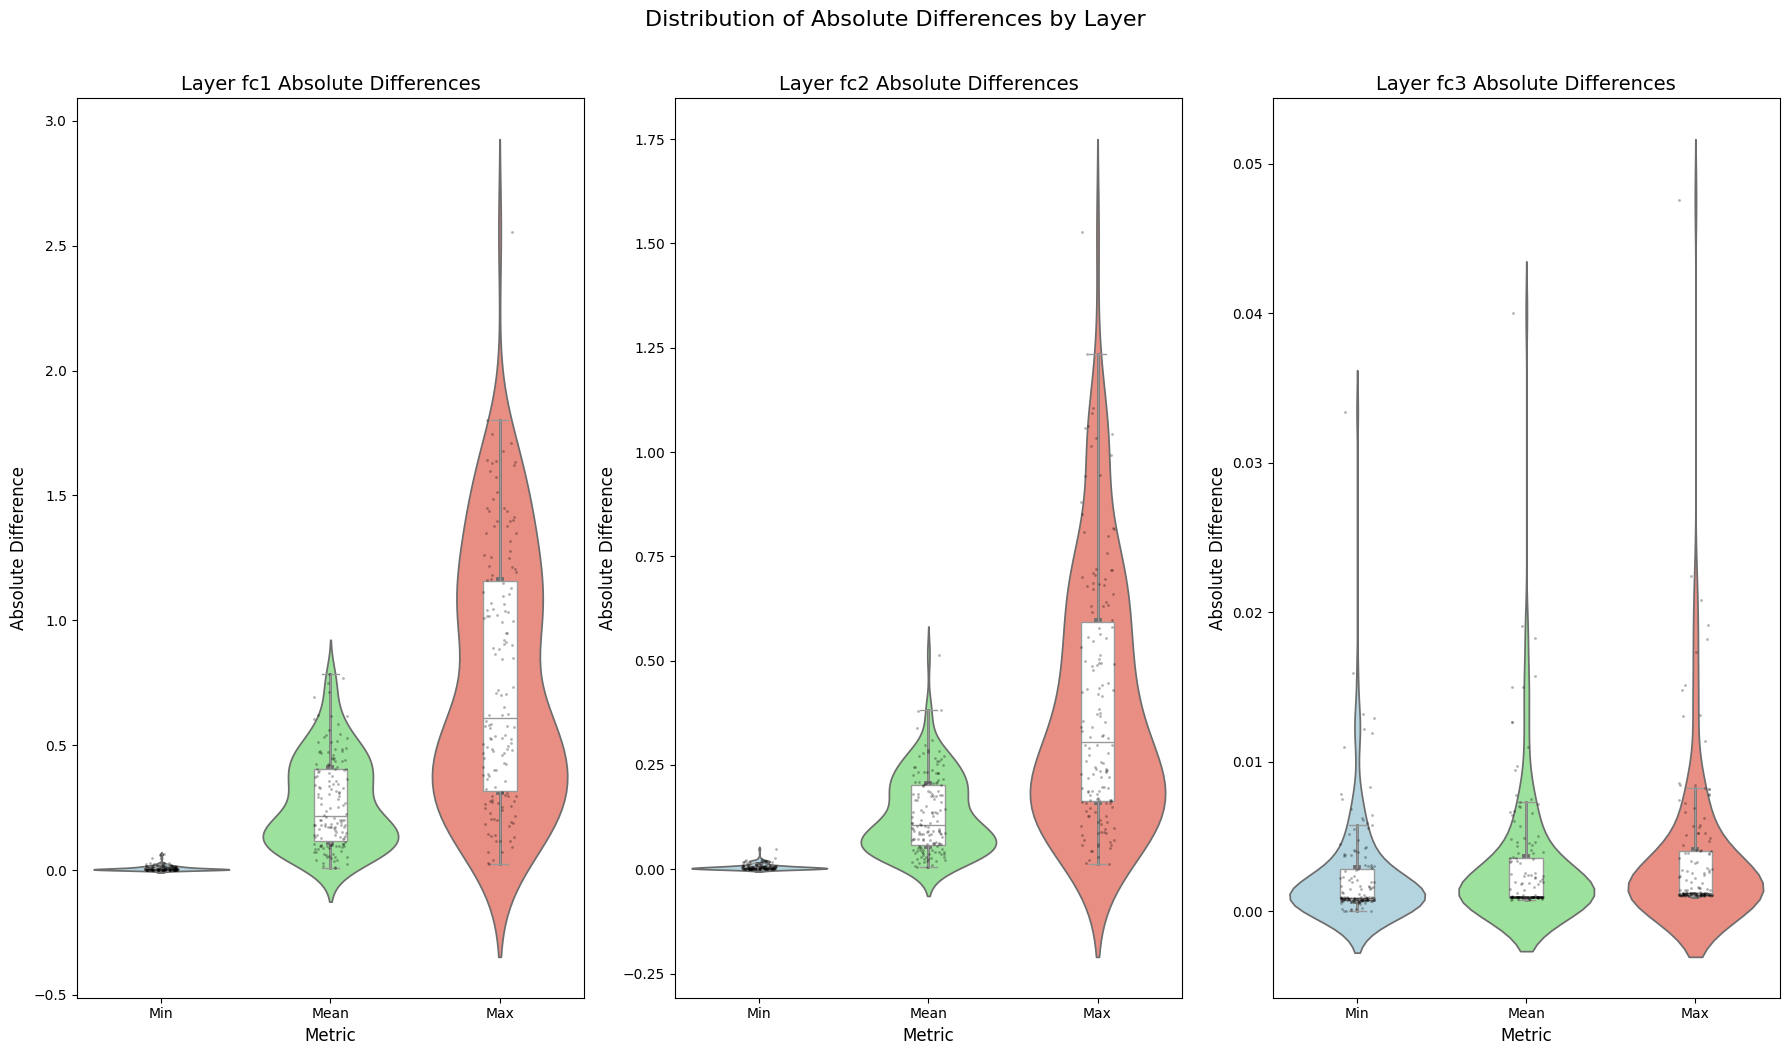

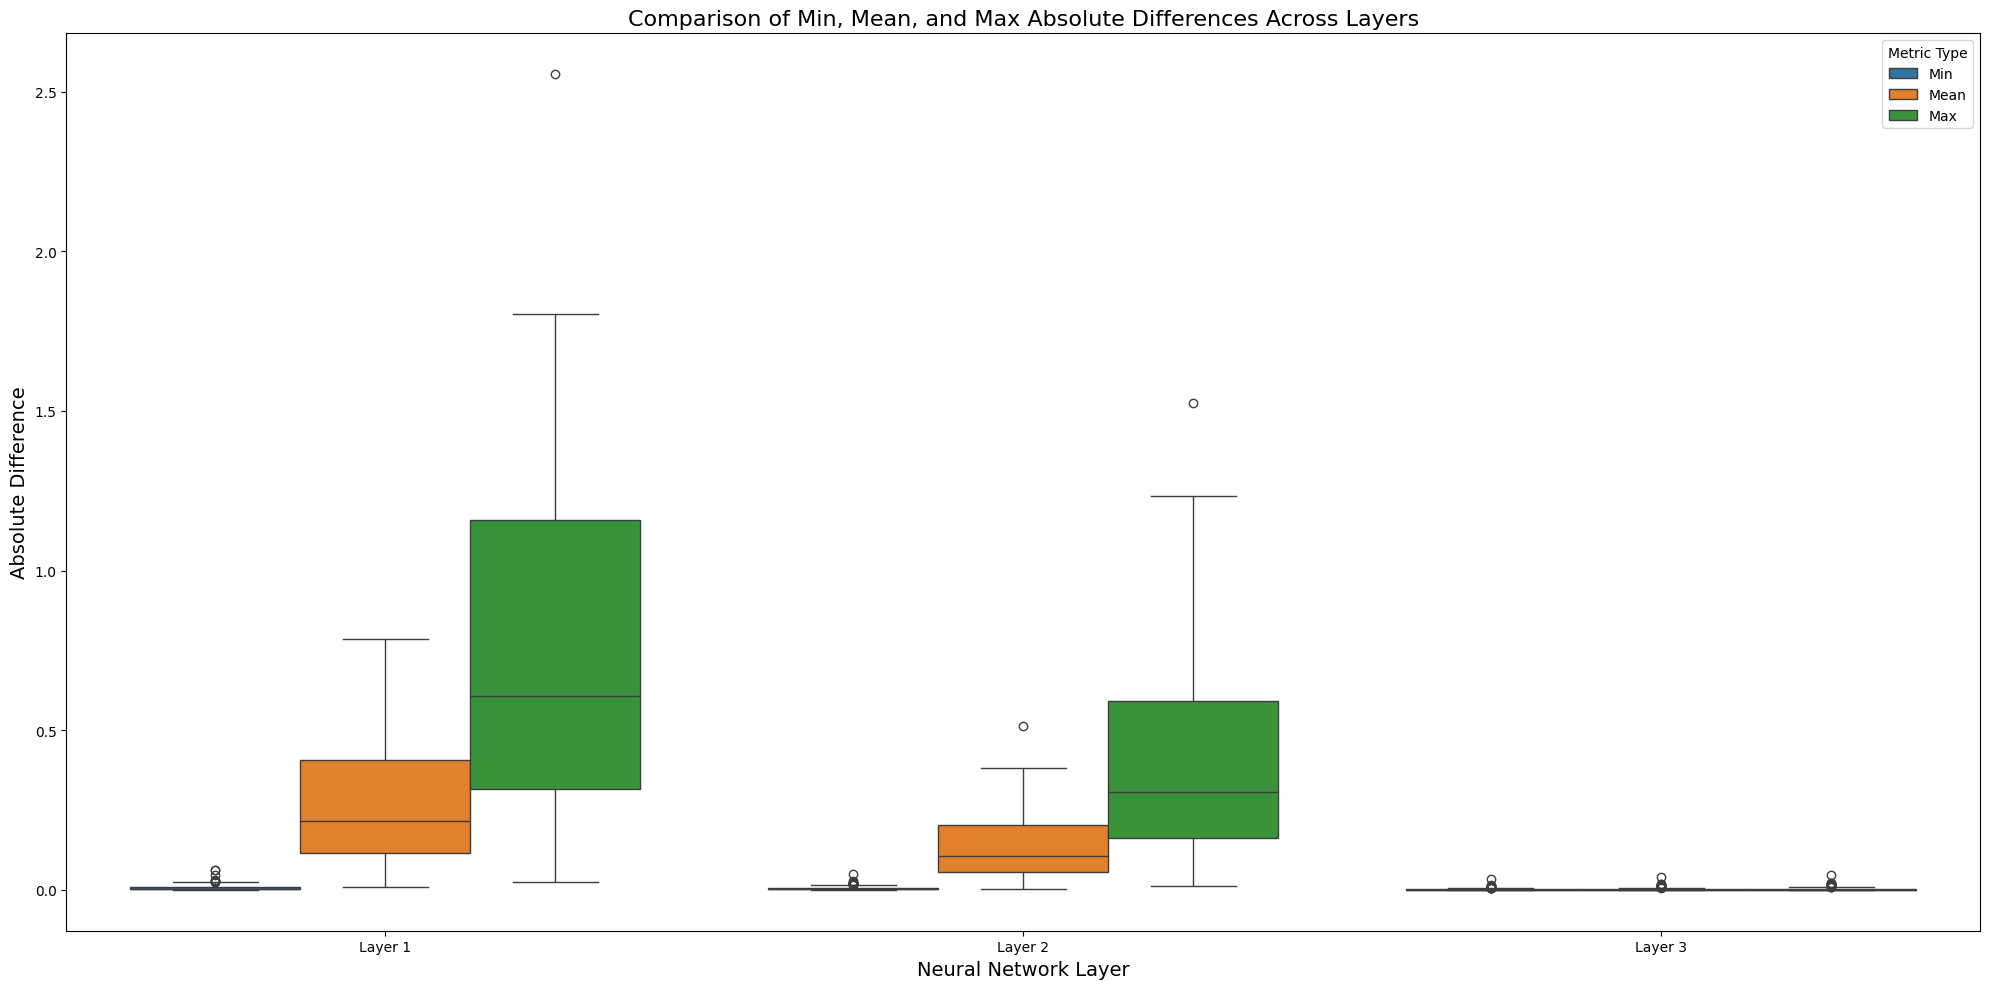

In [90]:

results = pd.DataFrame(pd.read_csv('activation_diff_results.csv'))

# Create figure for distribution plots
plt.figure(figsize=(18, 10))

# Define the layers and metrics
layers = ['fc1', 'fc2', 'fc3']
metrics = ['min_abs_diff', 'mean_abs_diff', 'max_abs_diff']
metric_labels = ['Min', 'Mean', 'Max']
colors = ['lightblue', 'lightgreen', 'salmon']

# Create combined subplot for each layer
for i, layer in enumerate(layers, 1):
    plt.subplot(1, 3, i)
    
    # Prepare data for this layer
    data = []
    labels = []
    
    for metric, label in zip(metrics, metric_labels):
        column = f'{layer}_{metric}'
        data.append(results[column].values)
        labels.extend([label] * len(results[column]))
    
    # Flatten the data for plotting
    flat_data = np.concatenate(data)
    
    # Create category labels
    categories = np.repeat(metric_labels, len(results))
    
    # Create violin plot
    sns.violinplot(x=categories, y=flat_data, palette=colors)
    
    # Add box plot inside for more detail
    sns.boxplot(x=categories, y=flat_data, width=0.2, 
                color='white', showfliers=False, zorder=2)
    
    # Add individual points with jitter for better visibility
    sns.stripplot(x=categories, y=flat_data, size=2, 
                 color='black', alpha=0.3, jitter=True)
    
    # Set plot title and labels
    plt.title(f'Layer {layer} Absolute Differences', fontsize=14)
    plt.xlabel('Metric', fontsize=12)
    plt.ylabel('Absolute Difference', fontsize=12)
    
    # Set y-axis to log scale if the range is very wide
    if results[f'{layer}_max_abs_diff'].max() / results[f'{layer}_min_abs_diff'].min() > 100:
        #plt.yscale('log')
        plt.ylabel('Absolute Difference')# (log scale)', fontsize=12)

plt.tight_layout()
plt.suptitle('Distribution of Absolute Differences by Layer', fontsize=16, y=1.05)
plt.savefig('layer_differences_distribution.png', bbox_inches='tight')
plt.show()

# Create a second figure with all metrics together for comparison
plt.figure(figsize=(20, 10))

# Prepare data for combined plot
all_data = []
all_labels = []
all_layer_labels = []

for layer in layers:
    for metric in metrics:
        column = f'{layer}_{metric}'
        all_data.append(results[column].values)
        all_labels.extend([f"{metric.split('_')[0].capitalize()}"] * len(results[column]))
        all_layer_labels.extend([f"Layer {layer.replace('fc', '')}"] * len(results[column]))

# Convert to arrays
all_data_flat = np.concatenate(all_data)
all_labels = np.array(all_labels)
all_layer_labels = np.array(all_layer_labels)

# Create DataFrame for seaborn
plot_df = pd.DataFrame({
    'Metric': all_labels,
    'Layer': all_layer_labels,
    'Value': all_data_flat
})

# Create the combined plot
sns.boxplot(x='Layer', y='Value', hue='Metric', data=plot_df)
plt.title('Comparison of Min, Mean, and Max Absolute Differences Across Layers', fontsize=16)
plt.xlabel('Neural Network Layer', fontsize=14)
plt.ylabel('Absolute Difference', fontsize=14)
plt.legend(title='Metric Type')

# Check if log scale is needed
if plot_df['Value'].max() / plot_df['Value'].min() > 100:
    #plt.yscale('log')
    plt.ylabel('Absolute Difference')# (log scale)', fontsize=14)

plt.tight_layout()
plt.savefig('combined_layer_differences.png')
plt.show()
